In [200]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import T5Tokenizer, T5ForConditionalGeneration
from src.utils.samp_utils import gen_row, get_reward_single, get_reward_double
from statistics import mean, stdev
from src.utils.hack_utils import modify_hyps, score_mhyp, competency_analysis
import re



device='cuda:0'

In [39]:
%load_ext autoreload
%autoreload 2

In [2]:
steamtok = T5Tokenizer.from_pretrained('stanfordnlp/SteamSHP-flan-t5-xl')
steamshp = T5ForConditionalGeneration.from_pretrained('stanfordnlp/SteamSHP-flan-t5-xl').to(device)
steamshp.eval()
print("loaded")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

loaded


In [ ]:
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-xxl")
genmodel = T5ForConditionalGeneration.from_pretrained("google/flan-t5-xxl", device_map="auto")#.to(device)
genmodel.eval()
print("loaded")

In [8]:
def hypsco_pairs(indf):
    allscos = []
    allhyps = []
    for ind, row in indf.iterrows():
        allscos.extend(row['scos'])
        allhyps.extend(row['hyps'])
    return allscos, allhyps

data = pd.read_json("output/rawdata/bigdsetp1.jsonl", orient='records', lines=True).drop(columns=['stats'])
ascos, ahyps = hypsco_pairs(data)

In [ ]:
companalysis = competency_analysis(ascos, ahyps)

In [118]:
probs, counts = companalysis

In [119]:
words = []
probvals = []
countvals = []
for k in probs.keys():
    words.append(k)
    probvals.append(probs[k])
    countvals.append(sum(counts[k]))

In [126]:
for i in range(len(words)):
    if probvals[i]<.2 and countvals[i]>50:
        print(words[i], " ", probvals[i], " ", countvals[i])

Is   0.17261904761904762   168
heat   0.15789473684210525   209
waves   0.12345679012345678   81
Each   0.16071428571428573   56
electricity   0.1643835616438356   73
dry   0.19696969696969696   66
travels   0.13333333333333333   60


In [18]:
inp, outs, _ = gen_row({'history':data['inp'][0]}, tokenizer, genmodel, 200, "sample", 2, .9)
shp_scores = [float(get_reward_single({"context": inp, "hyp":o}, steamtok, steamshp)) for o in outs]

In [ ]:
print(outs)
print(shp_scores)

In [56]:
mhyps = modify_hyps(list(data['scos']), list(data['hyps']), list(data['inp']))

In [67]:
heurscores = []
for m in mhyps:
    print(len(heurscores))
    heurscores.append(score_mhyp(m, steamtok, steamshp, True))

812
813
814


In [209]:
addscos = []
addsent = ""
for i in range(len(hscodf)):
    scotmp = float(get_reward_double({"context": hscodf['inp'][i], "hyp":addsent, "comp":hscodf['lsent'][i]}, steamtok, steamshp))
    addscos.append(scotmp)
    print(scotmp)
hscodf['research_hack_sco_h'] = addscos

0.9223629832267761
0.9566524624824524
0.9381784796714783
0.9018288850784302
0.5499758124351501
0.8421530723571777
0.8827367424964905
0.7924007773399353
0.9188359975814819
0.8979532122612
0.865385890007019
0.6713961362838745
0.8964040875434875
0.8845836520195007
0.918313205242157
0.6031108498573303
0.9297599792480469
0.8211050033569336
0.8872085809707642
0.8505074977874756
0.7182126641273499
0.8236317038536072
0.8272920846939087
0.8686907887458801
0.5491950511932373
0.8800878524780273
0.9433391690254211
0.8820124268531799
0.8681997656822205
0.9157498478889465
0.871453583240509
0.857115626335144
0.8637531995773315
0.9005765318870544
0.8903903961181641



KeyboardInterrupt



In [190]:
hscodf['research_hack_sco_h'].mean()

0.9148354652469144

In [69]:
hscodf = pd.DataFrame(heurscores)

In [84]:
keyval = "dup_lower_score"
print(stdev(hscodf[keyval]))
print(mean(hscodf[keyval]))

0.11756357232079091
0.6217412439317791


(array([  4.,  11.,  22.,  57., 145., 241., 263.,  68.,   2.,   2.]),
 array([-0.59502801, -0.51024978, -0.42547156, -0.34069333, -0.2559151 ,
        -0.17113687, -0.08635864, -0.00158041,  0.08319781,  0.16797604,
         0.25275427]),
 <BarContainer object of 10 artists>)

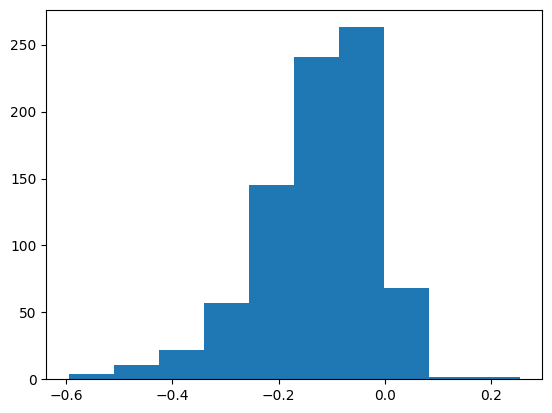

In [90]:
plt.hist(hscodf.first_add_score-hscodf.hsco)

In [65]:
score_mhyp(mhyps[0], steamtok, steamshp)

first_add
last_add
first_rep
last_rep
dup_lower


{'lsent': 'Is this a practical or theoretical issue? I have seen people say 10 cents, but I have not seen anyone state what this difference is based on.',
 'hsent': "The fact that the gas is a tier, and that the price is usually a 10 cents difference is very telling. People tend to think of gas as an arbitrary tier, but actually it isn't. Typically the gas is a tier in the price structure, but the tier in price is always 10 cents off the next tier.",
 'lsco': 0.3256509602,
 'hsco': 0.9307213426000001,
 'first_add': 'The fact that the gas is a tier, and that the price is usually a 10 cents difference is very telling. Is this a practical or theoretical issue? I have seen people say 10 cents, but I have not seen anyone state what this difference is based on.',
 'first_add_score': 0.7327279448509216,
 'last_add': 'Is this a practical or theoretical issue? I have seen people say 10 cents, but I have not seen anyone state what this difference is based on. Typically the gas is a tier in the p

In [31]:
def qcond(instr):
    return '?' in instr[:50]
        
def occur_distr(scores, outputs, cond):
    condhyps = []
    condscos = []
    for i in range(len(outputs)):
        if cond(outputs[i]):
            condhyps.append(outputs[i])
            condscos.append(scores[i])
    return condhyps, condscos
            

In [34]:
qhyps, qscos = occur_distr(ascos, ahyps, qcond)
print(mean(qscos))

0.716610349939394


(array([ 2.,  4.,  5.,  9., 11., 14., 11., 33., 24., 19.]),
 array([0.18907288, 0.26827275, 0.34747262, 0.42667249, 0.50587236,
        0.58507223, 0.66427211, 0.74347198, 0.82267185, 0.90187172,
        0.98107159]),
 <BarContainer object of 10 artists>)

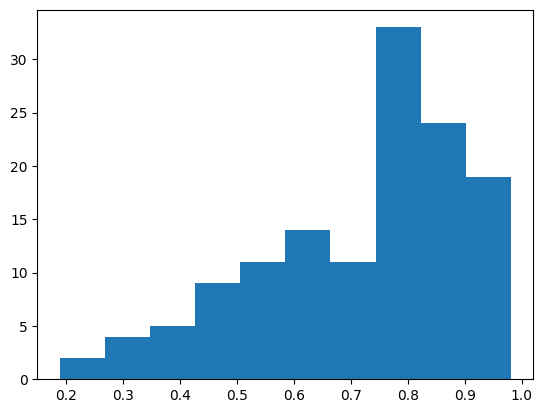

In [35]:
plt.hist(qscos)

In [36]:
print(list(zip(qscos[:10], qhyps[:10])))

[(0.3256509602, 'Is this a practical or theoretical issue? I have seen people say 10 cents, but I have not seen anyone state what this difference is based on.'), (0.7998151779, "Why didn't the turtle eat? The turtle eats because it lives in a warm climate. The turtle lives on a hot island."), (0.8292976022, "I'm not sure what you mean by make money? You're comparing rental income with mortgage payments. Rent is what you get in exchange for the use of a house, which is what the landlord invests in. He pays himself interest on the investment. It would take you months to pay off the mortgage, so the money is going to come out of the tenants' rents. If you're lucky, your landlord will raise the rent to cover the expenses he's having to pay for the property. Eventually, his profits will be bigger than his expenses."), (0.4641477764, 'What causes the urinate twice as much back out?always wondered this never have gotten an answer'), (0.9014465809000001, "What are the main changes to Paypal's 

(array([  3.,   6.,   8.,  32.,  80.,  92., 133., 183., 181., 107.]),
 array([0.11633313, 0.20414906, 0.29196499, 0.37978092, 0.46759685,
        0.55541277, 0.6432287 , 0.73104463, 0.81886056, 0.90667648,
        0.99449241]),
 <BarContainer object of 10 artists>)

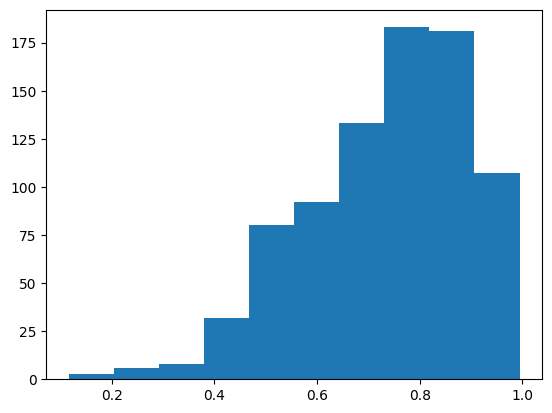

In [27]:
plt.hist(qscos)

In [13]:
data

,inp,hyps,scos,ver,pref,prefix
0,Why are different tiers (regular < mid < premi...,[Is this a practical or theoretical issue? I h...,"[0.3256509602, 0.9307213426000001, 0.765635073...",first,0.0,NaN
1,Why are different tiers (regular < mid < premi...,"[The fact that the gas is a tier, and that the...","[0.9758809805, 0.9251629710000001, 0.967072069...",rand,NaN,53.0
2,Stars and VisibilityWhy do stars in the night'...,[The ephemeris of a star can provide some info...,"[0.7836418152, 0.7945138216000001, 0.758988022...",first,0.0,NaN
3,Stars and VisibilityWhy do stars in the night'...,[The eponymous dark-adapted eye (DAE) may seem...,"[0.9133156538, 0.7046486139, 0.981576561900000...",rand,NaN,5.0
4,How do we know all the money the government is...,[JPMorgan Chase’s record $13 billion mortgage ...,"[0.721021533, 0.7394787073, 0.8426040411, 0.67...",first,0.0,NaN
...,...,...,...,...,...,...
3003,Can't remember what it's calledWhen people loo...,"[It's called ""groupthink"". It's when you're un...","[0.9565895796, 0.9091305733, 0.9350448847, 0.8...",rand,NaN,4.0
3004,"Other than making room for other patients, why...",[Many dentists would rather see each patient a...,"[0.7729679346, 0.6318202615, 0.550170838800000...",first,0.0,NaN
3005,"Other than making room for other patients, why...","[As the patient, you probably feel that a visi...","[0.8107921481, 0.7608217001, 0.9219293594, 0.8...",rand,NaN,33.0
3006,Why does the law never go after rappers who co...,[The law only wants to deal with actual crimin...,"[0.8216223121, 0.8157137632, 0.80394274, 0.856...",first,0.0,NaN


In [10]:
len(ahyps)

12032

(array([  15.,   40.,  123.,  290.,  564.,  960., 1660., 2864., 3623.,
        1893.]),
 array([0.11273485, 0.20110694, 0.28947902, 0.3778511 , 0.46622318,
        0.55459526, 0.64296734, 0.73133942, 0.81971151, 0.90808359,
        0.99645567]),
 <BarContainer object of 10 artists>)

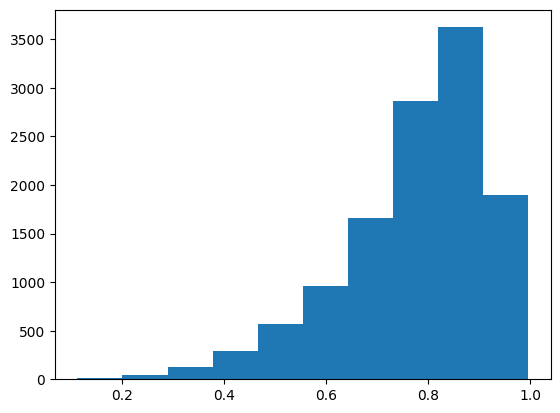

In [12]:
plt.hist(ascos)